Motorcycle dataset analysis, found at http://vincentarelbundock.github.io/Rdatasets/datasets.html under 'mcycle'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import GPy

from chained_gp.het_student_t import HetStudentT
from chained_gp.hetgp import HetGP

from chained_gp.svgp_multi import SVGPMulti

import matplotlib

data_dir = '../data_download/'

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 12, 3  # that's default image size for this 

Caching disabled: False


In [2]:
restarts = 10
n_folds = 5
Ms = ['all']#, 100]
#These are just starting values, lengthscales will also be randomized
f_rbf_len = 0.3
f_rbf_var = 0.5
g_rbf_len = 0.5
g_rbf_var = 0.5
# This is the log of mean of the posterior of the scale parameter, so we set it
# to be the log of roughly what we expect the scale parameter to be if it were
# constant
gauss_noise = 0.25
g_mean_val = np.log(gauss_noise)
g_bias_var = None
f_bias_var = None#['mean']
fixZ = True
preopt_scg_iters = 100
preopt_restarts = 3
scg_iters = 50
max_iters = 250
num_samples = 100000
gtol = 1e-5
ftol = 0
xtol = 0
#gauss_dataset_names = []#['elevators1000']#, 'elevators10000']
#stut_dataset_names = ['motorCorrupt', 'elevators1000']#, 'elevators10000']
starting_df = 4.0
optimize_df = True

fold = 0
seed = 0

In [3]:
np.random.seed(seed)

In [4]:
class Dataset(object):
    def __init__(self, Xtrain, Ytrain, Xtest, Ytest):
        self.Xtrain, self.Ytrain, self.Xtest, self.Ytest = Xtrain, Ytrain, Xtest, Ytest

def load_motorCorrupt(fold, seed):
    #Have merged the training and the test, and then put the header in the same file
    data = pd.read_csv(data_dir + 'mcycle.csv', index_col=0)
    data = data.reindex(np.random.permutation(data.index)) # Randomize so test isn't at the end
    X = data['times'].values[:, None]
    Y = data['accel'].values[:, None]
    X = (X-X.mean(0))/X.std(0)
    Y = (Y-Y.mean(0))/Y.std(0)

    from sklearn import cross_validation
    cv = cross_validation.KFold(n=X.shape[0], n_folds=n_folds, shuffle=True, random_state=seed)
    #Stupidly you can't just index it...
    for i, (train, test) in enumerate(cv):
        if i==fold:
            training_inds = train
            test_inds = test

    #Corrupt some Y's with larger noise
    corrupt_inds = np.random.permutation(range(X.shape[0]))[:25]
    Y[corrupt_inds] = np.random.randn(*Y[corrupt_inds].shape)*3.5

    Xtrain = X[training_inds, :]
    Ytrain = Y[training_inds, :]
    Xtest = X[test_inds, :]
    Ytest = Y[test_inds, :]

    #Corrupt 20 training Y's with larger noise
    #corrupt_inds = np.random.permutation(range(Xtrain.shape[0]))[:10]
    #Ytrain[corrupt_inds] += np.random.randn(*Ytrain[corrupt_inds].shape)*2.0

    print "training shape: ", Xtrain.shape
    print "test shape: ", Xtest.shape
    print "All: ", X.shape
    print Xtrain.shape[0] + Xtest.shape[0] - X.shape[0]
    return Dataset(Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest), corrupt_inds, X, Y

dataset, corrupt_inds, X, Y = load_motorCorrupt(fold, seed)
Xtrain = dataset.Xtrain
Ytrain = dataset.Ytrain
Xtest = dataset.Xtest
Ytest = dataset.Ytest

#X = np.concatenate((Xtrain, Xtest))
#Y = np.concatenate((Ytrain, Ytest))

training shape:  (106, 1)
test shape:  (27, 1)
All:  (133, 1)
0


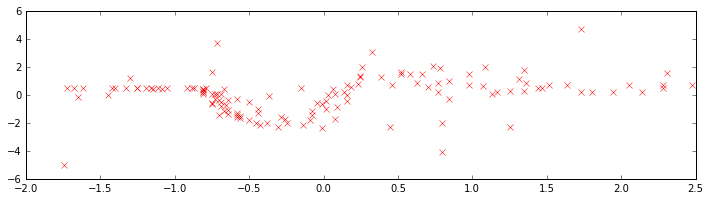

In [5]:
plt.plot(X, Y, 'rx')

In [6]:
def random_multi_lengthscales(X_):
    normed_X = (X_.max(0) - X_.min(0))/X_.std(0)
    #3 fluctuations in approximately the entire range
    print normed_X
    f_lengthscales = np.random.uniform(size=X_.shape[1])*(0.4/normed_X) + 0.001
    g_lengthscales = np.random.uniform(size=X_.shape[1])*(0.4/normed_X) + 0.001
    #f_lengthscales = X_.std(0)*np.random.uniform(size=X_train.shape[1])*0.05 + 0.001
    #g_lengthscales = X_.std(0)*np.random.uniform(size=X_train.shape[1])*0.05 + 0.001
    #f_lengthscales = np.abs(-0.5 + np.random.uniform(size=X_train.shape[1])*2.5)
    #g_lengthscales = np.abs(-0.5 + np.random.uniform(size=X_train.shape[1])*2.5)
    print f_lengthscales
    return f_lengthscales, g_lengthscales

random_multi_lengthscales(Xtrain)

[ 3.95013173]
[ 0.09021268]


(array([ 0.09021268]), array([ 0.0998731]))

In [7]:
def build_kernf(D, dataset, bias, f_rbf_len, f_rbf_var, seed, fold):
    kernf = GPy.kern.RBF(D, variance=f_rbf_var,
                         lengthscale=np.ones(D)*f_rbf_len, ARD=True,
                         name='kernf_rbf')
    #kernf += GPy.kern.Linear(D, ARD=True, name='kernf_linear')
    kernf += GPy.kern.White(1, variance=0.001, name='f_white')
    if bias is not None:
        if bias == 'mean':
            f_bias_var = dataset.Ytrain.mean()
        else:
            f_bias_var = bias
            kernf += GPy.kern.Bias(1, variance=f_bias_var, name='f_bias')
    kernf.f_white.fix()
    kernf.name = 'kernf'
    return kernf

def build_kerng(D, g_bias, g_rbf_len, seed, fold):
    #Needs white or variance doesn't checkgrad!
    kerng = GPy.kern.RBF(D, variance=g_rbf_var,
                         lengthscale=np.ones(D)*g_rbf_len, ARD=True,
                         name='kerng_rbf')
    kerng += GPy.kern.White(1, variance=0.001, name='g_white')
    if g_bias is not None:
        kerng += GPy.kern.Bias(1, variance=g_bias, name='g_bias')
    kerng.g_white.fix()
    kerng.name = 'kerng'
    return kerng
from scipy.cluster.vq import kmeans as scipy_kmeans

def kmeans(dataset, k, seed):
    Z, _ = scipy_kmeans(dataset.Xtrain, k)
    return Z

def build_gauss_model(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold):
    D = dataset.Xtrain.shape[1]
    kernf = build_kernf(D, dataset, bias, f_rbf_len, f_rbf_var, seed, fold)
    m_gauss = GPy.models.SparseGPRegression(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z=Z.copy(), kernel=kernf)
    m_gauss.name='gauss_single'
    m_gauss.likelihood.variance[:] = gauss_noise
    return m_gauss

def preopt_gauss_scheme(m):
    m.kernf.constrain_positive()
    m.likelihood.variance.constrain_positive()
    if hasattr(m, 'Z'):
        m.Z.fix()
    m.optimize('bfgs', max_iters=preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    if hasattr(m, 'Z'):
        m.Z.unfix()
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    return m

def preopt_gauss(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, random_func, seed, fold):
    m = build_gauss_model(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold)
    print "PreOptimizing gauss ", m
    print m.kernf.kernf_rbf.lengthscale
    best_m = preopt_gauss_scheme(m)
    print "Found best gauss model"
    print best_m
    return best_m[:]


In [8]:
#m1.optimize(messages=1)
m1_opt = preopt_gauss(dataset, Xtrain.copy(), fixZ, f_bias_var, f_rbf_len, f_rbf_var, random_multi_lengthscales, seed, fold)
m1 = build_gauss_model(dataset, Xtrain.copy(), fixZ, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
m1[:] = m1_opt

PreOptimizing gauss  
Name : gauss_single
Objective : 297.252895177
Number of Parameters : 110
Number of Optimization Parameters : 109
Updates : True
Parameters:
  gauss_single.                |     value  |  constraints  |  priors
  inducing inputs              |  (106, 1)  |               |        
  kernf.kernf_rbf.variance     |       0.5  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |       0.3  |      +ve      |        
  kernf.f_white.variance       |     0.001  |   +ve fixed   |        
  Gaussian_noise.variance      |      0.25  |      +ve      |        
  index  |  gauss_single.kernf.kernf_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                0.30000000  |      +ve      |        
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s16  010   1.739286e+02   1.508643e-02 
    00s28  018   1.738995e+02   2.920487e-02 
    00s51  037   1.738808e+02   3.062670e-06 
Runtime:     00s51
Optimizati

 /Users/alansaul/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


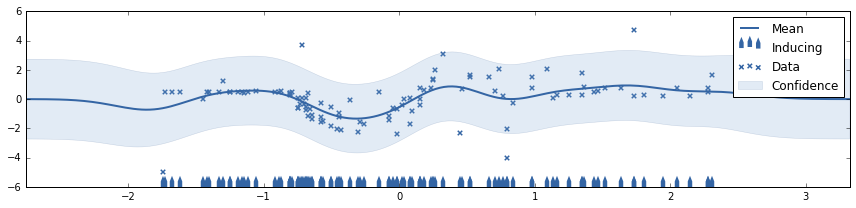

In [9]:
m1.plot()

In [10]:
print m1


Name : gauss_single
Objective : 173.880832636
Number of Parameters : 110
Number of Optimization Parameters : 109
Updates : True
Parameters:
  gauss_single.                |              value  |  constraints  |  priors
  inducing inputs              |           (106, 1)  |               |        
  kernf.kernf_rbf.variance     |     0.614510244628  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |     0.277123916017  |      +ve      |        
  kernf.f_white.variance       |  2.97952315372e-08  |   +ve fixed   |        
  Gaussian_noise.variance      |      1.32370465108  |      +ve      |        


In [11]:
#Make the kernels
D = dataset.Xtrain.shape[1]
kernf = build_kernf(D, dataset, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
kerng = build_kerng(D, g_bias_var, g_rbf_len, seed, fold)
kern = [kernf, kerng]

#Multiple latent process model
if g_mean_val is not None:
    g_mean = GPy.mappings.Constant(input_dim=13, output_dim=1, value=g_mean_val)
    print g_mean
mean_functions = [None, g_mean]
likelihood = HetGP()

Z = dataset.Xtrain.copy()
#Make the model
m2 = SVGPMulti(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z.copy(), kern_list=kern,
                    likelihood=likelihood, mean_functions=mean_functions, name='multi_gauss')


def pretrain_multi(m, randomize=True):
    if randomize:
        f_lens, g_lens = random_multi_lengthscales(m.X.values)
        m.kernf.kernf_rbf.lengthscale[:] = f_lens
        m.kernf.kernf_rbf.variance[:] = f_rbf_var
        m.kerng.kerng_rbf.lengthscale[:] = g_lens
        m.kerng.kerng_rbf.variance[:] = g_rbf_var
    m.kernf.fix()
    m.kerng.fix()
    if hasattr(m, 'Z'):
        m.Z.fix()
    if hasattr(m, 'constmap'):
        m.constmap.fix()
    print m

    #Optimize model with fixed parameters to get latent functions in place
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    #Constrain all kernel parameters positive and reoptimize
    m.kernf.constrain_positive()
    m.kerng.constrain_positive()
    m.kernf.f_white.fix()
    m.kerng.g_white.fix()
    if hasattr(m, 'constmap'):
        m.constmap.unfix()

    # Continue with optimization with everything released
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    #if hasattr(m, 'Z'):
    #    m.Z.unfix()
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)

    return m

m2 = pretrain_multi(m2)

  constmap.  |           value  |  constraints  |  priors
  C          |  -1.38629436112  |               |        
[ 3.95013173]
[ 0.08086968]

Name : multi_gauss
Objective : 39548.9828084
Number of Parameters : 11667
Number of Optimization Parameters : 11554
Updates : True
Parameters:
  multi_gauss.                 |            value  |  constraints  |  priors
  inducing inputs              |         (106, 1)  |     fixed     |        
  q_u_means                    |         (106, 2)  |               |        
  qf_u_chols                   |        (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |              0.5  |   +ve fixed   |        
  kernf.kernf_rbf.lengthscale  |  0.0808696834682  |   +ve fixed   |        
  kernf.f_white.variance       |            0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |              0.5  |   +ve fixed   |        
  kerng.kerng_rbf.lengthscale  |  0.0242338413092  |   +ve fixed   |        
  kerng.g_white.var

In [12]:
print m2


Name : multi_gauss
Objective : 149.054198023
Number of Parameters : 11667
Number of Optimization Parameters : 11559
Updates : True
Parameters:
  multi_gauss.                 |             value  |  constraints  |  priors
  inducing inputs              |          (106, 1)  |     fixed     |        
  q_u_means                    |          (106, 2)  |               |        
  qf_u_chols                   |         (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |    0.748852800073  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |    0.339295438162  |      +ve      |        
  kernf.f_white.variance       |             0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |     2.10280795023  |      +ve      |        
  kerng.kerng_rbf.lengthscale  |  0.00339158041807  |      +ve      |        
  kerng.g_white.variance       |             0.001  |   +ve fixed   |        
  constmap.C                   |   -0.988675254174  |               |       

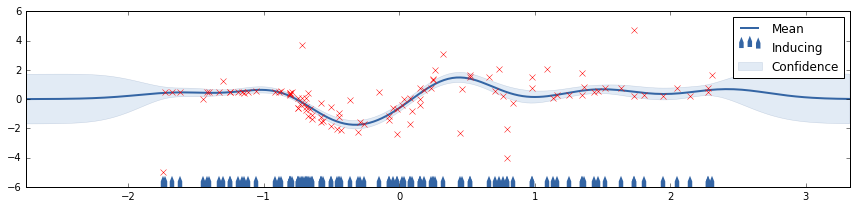

In [13]:
m2.plot_f()
plt.plot(Xtrain, Ytrain, 'rx')

In [14]:
#Make the kernels
D = dataset.Xtrain.shape[1]
kernf = build_kernf(D, dataset, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
kerng = build_kerng(D, g_bias_var, g_rbf_len, seed, fold)
kern = [kernf, kerng]

#Multiple latent process model
if g_mean_val is not None:
    g_mean = GPy.mappings.Constant(input_dim=13, output_dim=1, value=g_mean_val)
    print g_mean
mean_functions = [None, g_mean]
likelihood = HetGP()

Z = dataset.Xtrain.copy()
#Make the model
likelihood = HetStudentT(deg_free=starting_df)
m3 = SVGPMulti(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z.copy(), kern_list=kern,
                    likelihood=likelihood, mean_functions=mean_functions, name='multi_stut')


def pretrain_multi(m, randomize=True):
    if randomize:
        f_lens, g_lens = random_multi_lengthscales(m.X.values)
        m.kernf.kernf_rbf.lengthscale[:] = f_lens
        m.kernf.kernf_rbf.variance[:] = f_rbf_var
        m.kerng.kerng_rbf.lengthscale[:] = g_lens
        m.kerng.kerng_rbf.variance[:] = g_rbf_var
    m.kernf.fix()
    m.kerng.fix()
    if hasattr(m, 'Z'):
        m.Z.fix()
    if hasattr(m, 'constmap'):
        m.constmap.fix()
    print m

    #Optimize model with fixed parameters to get latent functions in place
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    #Constrain all kernel parameters positive and reoptimize
    m.kernf.constrain_positive()
    m.kerng.constrain_positive()
    m.kernf.f_white.fix()
    m.kerng.g_white.fix()
    if hasattr(m, 'constmap'):
        m.constmap.unfix()

    # Continue with optimization with everything released
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    #if hasattr(m, 'Z'):
    #    m.Z.unfix()
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)

    return m

m3 = pretrain_multi(m3)

  constmap.  |           value  |  constraints  |  priors
  C          |  -1.38629436112  |               |        
[ 3.95013173]
[ 0.08679717]

Name : multi_stut
Objective : 49736.0155909
Number of Parameters : 11668
Number of Optimization Parameters : 11554
Updates : True
Parameters:
  multi_stut.                  |            value  |  constraints  |  priors
  inducing inputs              |         (106, 1)  |     fixed     |        
  Hetro_Student_T.deg_free     |              4.0  |   +ve fixed   |        
  q_u_means                    |         (106, 2)  |               |        
  qf_u_chols                   |        (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |              0.5  |   +ve fixed   |        
  kernf.kernf_rbf.lengthscale  |  0.0867971713558  |   +ve fixed   |        
  kernf.f_white.variance       |            0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |              0.5  |   +ve fixed   |        
  kerng.kerng_rbf.le

In [15]:
m1.Z.unfix()
m2.Z.unfix()
m3.Z.unfix()
m1.optimize('bfgs', max_iters=3000, messages=1)
print m1
m2.optimize('bfgs', max_iters=3000, messages=1)
print m2
m3.optimize('bfgs', max_iters=3000, messages=1)
print m3

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   1.794427e+02   2.647319e+02 
    00s04  0004   1.738808e+02   3.708823e-07 
Runtime:     00s04
Optimization status: Converged


Name : gauss_single
Objective : 173.880832592
Number of Parameters : 110
Number of Optimization Parameters : 109
Updates : True
Parameters:
  gauss_single.                |              value  |  constraints  |  priors
  inducing inputs              |           (106, 1)  |               |        
  kernf.kernf_rbf.variance     |     0.614481229451  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |     0.277139032745  |      +ve      |        
  kernf.f_white.variance       |  2.97952315372e-08  |   +ve fixed   |        
  Gaussian_noise.variance      |      1.32366475514  |      +ve      |        
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s29  0005   1.490542e+02   5.012508e-01 
    00s48

In [16]:
m3_free_df = m3.copy()
m3_free_df.Z.fix()
m3_free_df.likelihood.deg_free.constrain_positive()
m3_free_df.optimize('scg', messages=1, max_iters=50)

Running Scaled Conjugate Gradients Code:
  runtime   i    f              |g|        
    00s27  08   1.433116e+02   5.869234e+01 
    01s20  54   1.426390e+02   8.207087e+00 
    03s93  152   1.420495e+02   1.578275e+01 
Runtime:     03s93
Optimization status: maxiter exceeded



In [17]:
#m3_free_df.Z.unfix()
m3_free_df.optimize('scg', messages=1, max_iters=200)
m3_free_df.optimize('bfgs', messages=1, max_iters=2000)

Running Scaled Conjugate Gradients Code:
  runtime   i     f              |g|        
    00s05  002   1.420495e+02   1.630991e+01 
    00s28  008   1.420292e+02   1.135898e+01 
    00s89  036   1.419156e+02   1.262498e+01 
    04s00  141   1.415680e+02   2.241280e+01 
    10s56  435   1.400574e+02   4.245736e+00 
    15s19  602   1.398263e+02   4.950666e+00 
Runtime:     15s19
Optimization status: maxiter exceeded

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s08  0002   4.126613e+02   1.485144e+06 
    00s26  0005   1.398190e+02   1.457861e+00 
    01s52  0041   1.397688e+02   2.841955e+00 
    05s11  0137   1.394231e+02   2.147361e+00 
    13s01  0394   1.373723e+02   6.671132e+01 
    25s66  0857   1.358099e+02   1.601923e-01 
    28s47  0969   1.358046e+02   1.537248e-02 
    31s33  1086   1.358035e+02   3.432293e-03 
    32s05  1116   1.358035e+02   2.844751e-03 
Runtime:     32s05
Optimization status: Converged



In [18]:
m3_free_df

multi_stut.,value,constraints,priors
inducing inputs,"(106, 1)",fixed,
Hetro_Student_T.deg_free,1.33035035097,+ve,
q_u_means,"(106, 2)",,
qf_u_chols,"(5671, 2)",,
kernf.kernf_rbf.variance,0.644621420741,+ve,
kernf.kernf_rbf.lengthscale,0.265937076398,+ve,
kernf.f_white.variance,0.001,+ve fixed,
kerng.kerng_rbf.variance,2.433154043,+ve,
kerng.kerng_rbf.lengthscale,0.390646296773,+ve,
kerng.g_white.variance,0.001,+ve fixed,


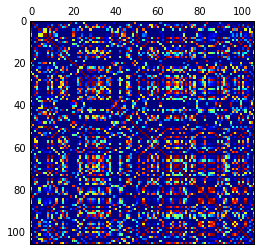

In [19]:
plt.matshow(m3.kernf.K(m3.X))

In [20]:
print m1


Name : gauss_single
Objective : 173.880832592
Number of Parameters : 110
Number of Optimization Parameters : 109
Updates : True
Parameters:
  gauss_single.                |              value  |  constraints  |  priors
  inducing inputs              |           (106, 1)  |               |        
  kernf.kernf_rbf.variance     |     0.614481229451  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |     0.277139032745  |      +ve      |        
  kernf.f_white.variance       |  2.97952315372e-08  |   +ve fixed   |        
  Gaussian_noise.variance      |      1.32366475514  |      +ve      |        


In [21]:
print m2


Name : multi_gauss
Objective : 149.054192611
Number of Parameters : 11667
Number of Optimization Parameters : 11665
Updates : True
Parameters:
  multi_gauss.                 |            value  |  constraints  |  priors
  inducing inputs              |         (106, 1)  |               |        
  q_u_means                    |         (106, 2)  |               |        
  qf_u_chols                   |        (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |   0.748853085134  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |   0.339295295775  |      +ve      |        
  kernf.f_white.variance       |            0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |    2.10280793312  |      +ve      |        
  kerng.kerng_rbf.lengthscale  |  0.0033915789361  |      +ve      |        
  kerng.g_white.variance       |            0.001  |   +ve fixed   |        
  constmap.C                   |  -0.988675088243  |               |        


In [22]:
print m3


Name : multi_stut
Objective : 143.354628037
Number of Parameters : 11668
Number of Optimization Parameters : 11665
Updates : True
Parameters:
  multi_stut.                  |            value  |  constraints  |  priors
  inducing inputs              |         (106, 1)  |               |        
  Hetro_Student_T.deg_free     |              4.0  |   +ve fixed   |        
  q_u_means                    |         (106, 2)  |               |        
  qf_u_chols                   |        (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |   0.731412444013  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |   0.318096185315  |      +ve      |        
  kernf.f_white.variance       |            0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |    2.99876783401  |      +ve      |        
  kerng.kerng_rbf.lengthscale  |  0.0664788036712  |      +ve      |        
  kerng.g_white.variance       |            0.001  |   +ve fixed   |        
  constmap

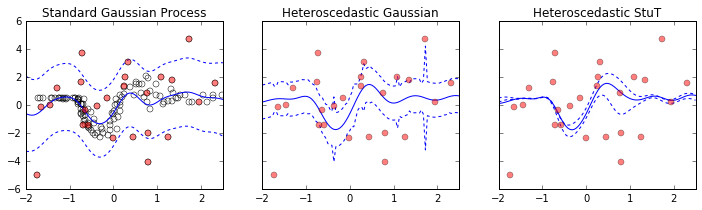

In [23]:
sort_inds = X.argsort(axis=0)
X_sorted = X[sort_inds].reshape(X.shape[0], 1)
Y_sorted = Y[sort_inds].reshape(X.shape[0], 1)


X_full = np.linspace(-2, 2.5, 100)[:, None]
mu_gauss, var_gauss = m1.predict(X_full)
mu_multi_gauss, _ = m2._raw_predict(X_full, 0)
var_multi_gauss, _ = m2._raw_predict(X_full, 1)
mu_multi_stut, _ = m3._raw_predict(X_full, 0)
var_multi_stut, _ = m3._raw_predict(X_full, 1)
mu_multi_stut_free_df, _ = m3_free_df._raw_predict(X_full, 0)
var_multi_stut_free_df, _ = m3_free_df._raw_predict(X_full, 1)

#outlier = Y_sorted > (mu_multi_stut + 3*np.sqrt(np.exp(var_multi_stut)))
dashes = (3,3)
calpha = 0.5
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.plot(X_sorted, Y_sorted, 'o', mfc='none')
ax1.plot(X_full, mu_gauss, 'b-')
ax1.plot(X_full, mu_gauss + 2*np.sqrt(var_gauss), 'b--', dashes=dashes)
ax1.plot(X_full, mu_gauss - 2*np.sqrt(var_gauss), 'b--', dashes=dashes)
ax1.set_title('Standard Gaussian Process')
ax1.plot(X[corrupt_inds], Y[corrupt_inds], 'ro', alpha=calpha)

ax2.plot(X_sorted, Y_sorted, 'o', mfc='none', alpha=0.01)
ax2.plot(X_full, mu_multi_gauss, 'b-')
ax2.plot(X_full, mu_multi_gauss + 2*np.sqrt(np.exp(var_multi_gauss)), 'b--', dashes=dashes)
ax2.plot(X_full, mu_multi_gauss - 2*np.sqrt(np.exp(var_multi_gauss)), 'b--', dashes=dashes)
ax2.set_title('Heteroscedastic Gaussian')
ax2.plot(X[corrupt_inds], Y[corrupt_inds], 'ro', alpha=calpha)


#ax3.plot(X_sorted, Y_sorted, 'o', mfc='none', alpha=0.01)
#ax3.plot(X_full, mu_multi_stut, 'b-')
#df = m3.likelihood.deg_free
#real_multi_stut_var = (df / (df - 2.0))*np.exp(var_multi_stut)
#ax3.plot(X_full, mu_multi_stut + real_multi_stut_var, 'b--', dashes=dashes)
#ax3.plot(X_full, mu_multi_stut - real_multi_stut_var, 'b--', dashes=dashes)
#ax3.set_title('Heteroscedastic StuT')
#ax3.plot(X[corrupt_inds], Y[corrupt_inds], 'ro', alpha=calpha)

#With df free
ax3.plot(X_sorted, Y_sorted, 'o', mfc='none', alpha=0.01)
ax3.plot(X_full, mu_multi_stut, 'b-')
df = m3_free_df.likelihood.deg_free
real_multi_stut_var = (df / (df - 2.0))*np.exp(var_multi_stut_free_df)
ax3.plot(X_full, mu_multi_stut_free_df + real_multi_stut_var, 'b--', dashes=dashes)
ax3.plot(X_full, mu_multi_stut_free_df - real_multi_stut_var, 'b--', dashes=dashes)
ax3.set_title('Heteroscedastic StuT')
ax3.plot(X[corrupt_inds], Y[corrupt_inds], 'ro', alpha=calpha)

import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_locator(loc)
ax3.xaxis.set_major_locator(loc)

#plt.rcParams['text.latex.unicode']=True
#plt.rcParams['text.usetex']=True
#plt.rcParams['pgf.texsystem'] = 'pdflatex'
#fig.savefig('corrupt_motorcycleeps.eps', dpi=500)

#from matplotlib2tikz import save as tikz_save
#tikz_save('corrupt_motorcycle_all.tikz', figure=fig)